Just pretend you are the bioinformatician at the Covid-19 surveillance center of Wakanda (I chose a place that doesn't exist, because no one wants new waves or new variants)


We have sequenced six genomes and processed them as you learned yesterday.
Pangolin identifies our six genomes as part of lineage "U.3" (a sublineage of B.1.177, the UK variant / Kent variant / Alpha variant)

Are they a new lineage, intead? A new variant derived from the U.3? We will need to compare them with genomes that are available from public databases and see if they are eligible for a new Pango lineage proposal (see guidelines at https://www.pango.network/the-pango-nomenclature-system/statement-of-nomenclature-rules/)

We will download all available genomes and metadata from the GISAID database (for this practice, we will use a very narrow subset). We will use python and recall a couple of stand-alone programs to do this

Let's start!

First of all we will need to load python libraries

In [41]:
import sys
from Bio import SeqIO
import pandas as pd
import numpy as np
import os
from Bio import AlignIO
import operator
from Bio import Phylo
import matplotlib as mpl
from Bio.Align import MultipleSeqAlignment
import collections

And open the metadata file as a dataframe using the library pandas (pd)

In [8]:
df = pd.read_csv("Gisaid_metadata_subset.tsv", sep="\t")

print(df)

                                  Virus name             Type  \
0           hCoV-19/England/QEUH-96DE86/2020  betacoronavirus   
1           hCoV-19/England/QEUH-9B9EE5/2020  betacoronavirus   
2           hCoV-19/England/ALDP-9BDA0B/2020  betacoronavirus   
3           hCoV-19/England/ALDP-9C51B0/2020  betacoronavirus   
4           hCoV-19/England/ALDP-9BDFC0/2020  betacoronavirus   
..                                       ...              ...   
117                 hCoV-19/Latvia/1867/2021  betacoronavirus   
118        hCoV-19/England/LOND-128D2E2/2020  betacoronavirus   
119                 hCoV-19/Latvia/2115/2021  betacoronavirus   
120                 hCoV-19/Latvia/2287/2021  betacoronavirus   
121  hCoV-19/England/GSTT-201204GN2BC56/2020  betacoronavirus   

        Accession ID Collection date                           Location  \
0     EPI_ISL_530531      2020-08-18  Europe / United Kingdom / England   
1     EPI_ISL_549601      2020-09-07  Europe / United Kingdom / Engla

Now we need to select high quality genomes, i.e. :

a) complete

b) high coverage

c) low number of N positions. In our case, at most 0.1% of the genome (~30 nucleotides) is "N"

In [9]:
df2=df[(df["Is complete?"] == True) & (df["Is high coverage?"] == True)]
df3=df2[(df2["N-Content"] <= 0.001) | (df2["N-Content"].isna()) ]
LL=df3["Virus name"].to_list()

print("We have selected %i genomes" %(len(LL)))

We have selected 98 genomes


Now we build a fasta file with the selected genome. We will add the Pango lineage to the name (it will be useful to understand the phylogenetic tree)

We also add the reference genome and those that we sequenced in our lab

In [10]:
outF=open("selected_for_phylogeny.fasta","w")

df3.set_index("Virus name",inplace=True)

for i in SeqIO.parse("Gisaid_sequences_subset.fasta","fasta"):
    if str(i.id).strip().split("|")[0] in LL:
        i.id=str(i.id).strip().split("|")[0]+"|"+str(df3.loc[str(i.id).strip().split("|")[0]]["Pango lineage"])
        SeqIO.write(i,outF,"fasta")

outF.close()


!cat Reference_SARS-CoV-2.fasta selected_for_phylogeny.fasta NEW.fasta > selected+reference.fasta

Let's take a look at our sequences now. We need to align them!

In [28]:
!seaview selected+reference.fasta

To align the sequences and visualize them again:

In [30]:
!mafft --auto selected+reference.fasta > selected+reference.fasta.aln

!seaview selected+reference.fasta.aln


nthread = 0
stacksize: 8192 kb
generating a scoring matrix for nucleotide (dist=200) ... done
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..

There are 110 ambiguous characters.
  101 / 101
done.

Constructing a UPGMA tree (efffree=0) ... 
   90 / 101
done.

Progressive alignment 1/2... 
STEP   100 / 100 f
done.

Making a distance matrix from msa.. 
    0 / 101
done.

Constructing a UPGMA tree (efffree=1) ... 
   90 / 101
done.

Progressive alignment 2/2... 
STEP   100 / 100 f
done.

disttbfast (nuc) Version 7.310 alg=A, model=DNA200 (2), 1.53 (4.59), -0.00 (-0.00), noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-2 (Fast but rough)
 Progressive method (guide trees were built 2 times.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scoring scheme has been changed in version 7.110 (2013 Oct).
It tends to insert more gaps into gap-rich regions than previous

=======

And now build the phylogenetic tree, and visualize it

In [ ]:
!iqtree -mset HKY,TIM2,GTR -mfreq F -mrate G,R -alrt 1000 -bb 1000 -s selected+reference.fasta.aln -T 2 -redo

IQ-TREE multicore version 2.1.2 COVID-edition for Linux 64-bit built Mar 30 2021
Developed by Bui Quang Minh, James Barbetti, Nguyen Lam Tung,
Olga Chernomor, Heiko Schmidt, Dominik Schrempf, Michael Woodhams.

Host:    ATAT (AVX512, FMA3, 125 GB RAM)
Command: iqtree -mset HKY,TIM2,GTR -mfreq F -mrate G,R -alrt 1000 -bb 1000 -s selected+reference.fasta.aln -T 2 -redo
Seed:    93804 (Using SPRNG - Scalable Parallel Random Number Generator)
Time:    Wed Jul 21 16:25:59 2021
Kernel:  AVX+FMA - 2 threads (32 CPU cores detected)

Reading alignment file selected+reference.fasta.aln ... Fasta format detected
Alignment most likely contains DNA/RNA sequences
Alignment has 101 sequences with 29904 columns, 231 distinct patterns
67 parsimony-informative, 104 singleton sites, 29733 constant sites
                                             Gap/Ambiguity  Composition  p-value
   1  NC_045512.2                                    0.00%    passed     98.83%
   2  hCoV-19/England/QEUH-96DE86/2020|W.3 

NOTE: 3 identical sequences (see below) will be ignored for subsequent analysis
NOTE: hCoV-19/England/QEUH-9DE248/2020|W.3 (identical to hCoV-19/England/QEUH-9FA3E9/2020|W.3) is ignored but added at the end
NOTE: hCoV-19/Latvia/1282/2021|U.3 (identical to hCoV-19/Latvia/1201/2021|U.3) is ignored but added at the end
NOTE: hCoV-19/Latvia/1456/2021|U.3 (identical to hCoV-19/Latvia/1201/2021|U.3) is ignored but added at the end
Alignment was printed to selected+reference.fasta.aln.uniqueseq.phy

For your convenience alignment with unique sequences printed to selected+reference.fasta.aln.uniqueseq.phy

Creating fast initial parsimony tree by random order stepwise addition...
0.018 seconds, parsimony score: 186 (based on 171 sites)
Perform fast likelihood tree search using GTR+I+G model...
Estimate model parameters (epsilon = 5.000)
Perform nearest neighbor interchange...
Estimate model parameters (epsilon = 1.000)
1. Initial log-likelihood: -42532.389
Optimal log-likelihood: -42532.373
Rat

Optimal log-likelihood: -42543.559
Rate parameters:  A-C: 0.47922  A-G: 1.12034  A-T: 0.47922  C-G: 1.00000  C-T: 5.00364  G-T: 1.00000
Base frequencies:  A: 0.299  C: 0.184  G: 0.196  T: 0.322
Gamma shape alpha: 0.020
Parameters optimization took 1 rounds (0.041 sec)
BEST SCORE FOUND : -42543.559

Testing tree branches by SH-like aLRT with 1000 replicates...
1.059 sec.
Creating bootstrap support values...
Split supports printed to NEXUS file selected+reference.fasta.aln.splits.nex
Total tree length: 0.006

Total number of iterations: 400
CPU time used for tree search: 199.590 sec (0h:3m:19s)
Wall-clock time used for tree search: 111.009 sec (0h:1m:51s)
Total CPU time used: 202.625 sec (0h:3m:22s)
Total wall-clock time used: 112.828 sec (0h:1m:52s)

Computing bootstrap consensus tree...
Reading input file selected+reference.fasta.aln.splits.nex...
98 taxa and 2562 splits.
Consensus tree written to selected+reference.fasta.aln.contree
Reading input trees file selected+reference.fasta.al

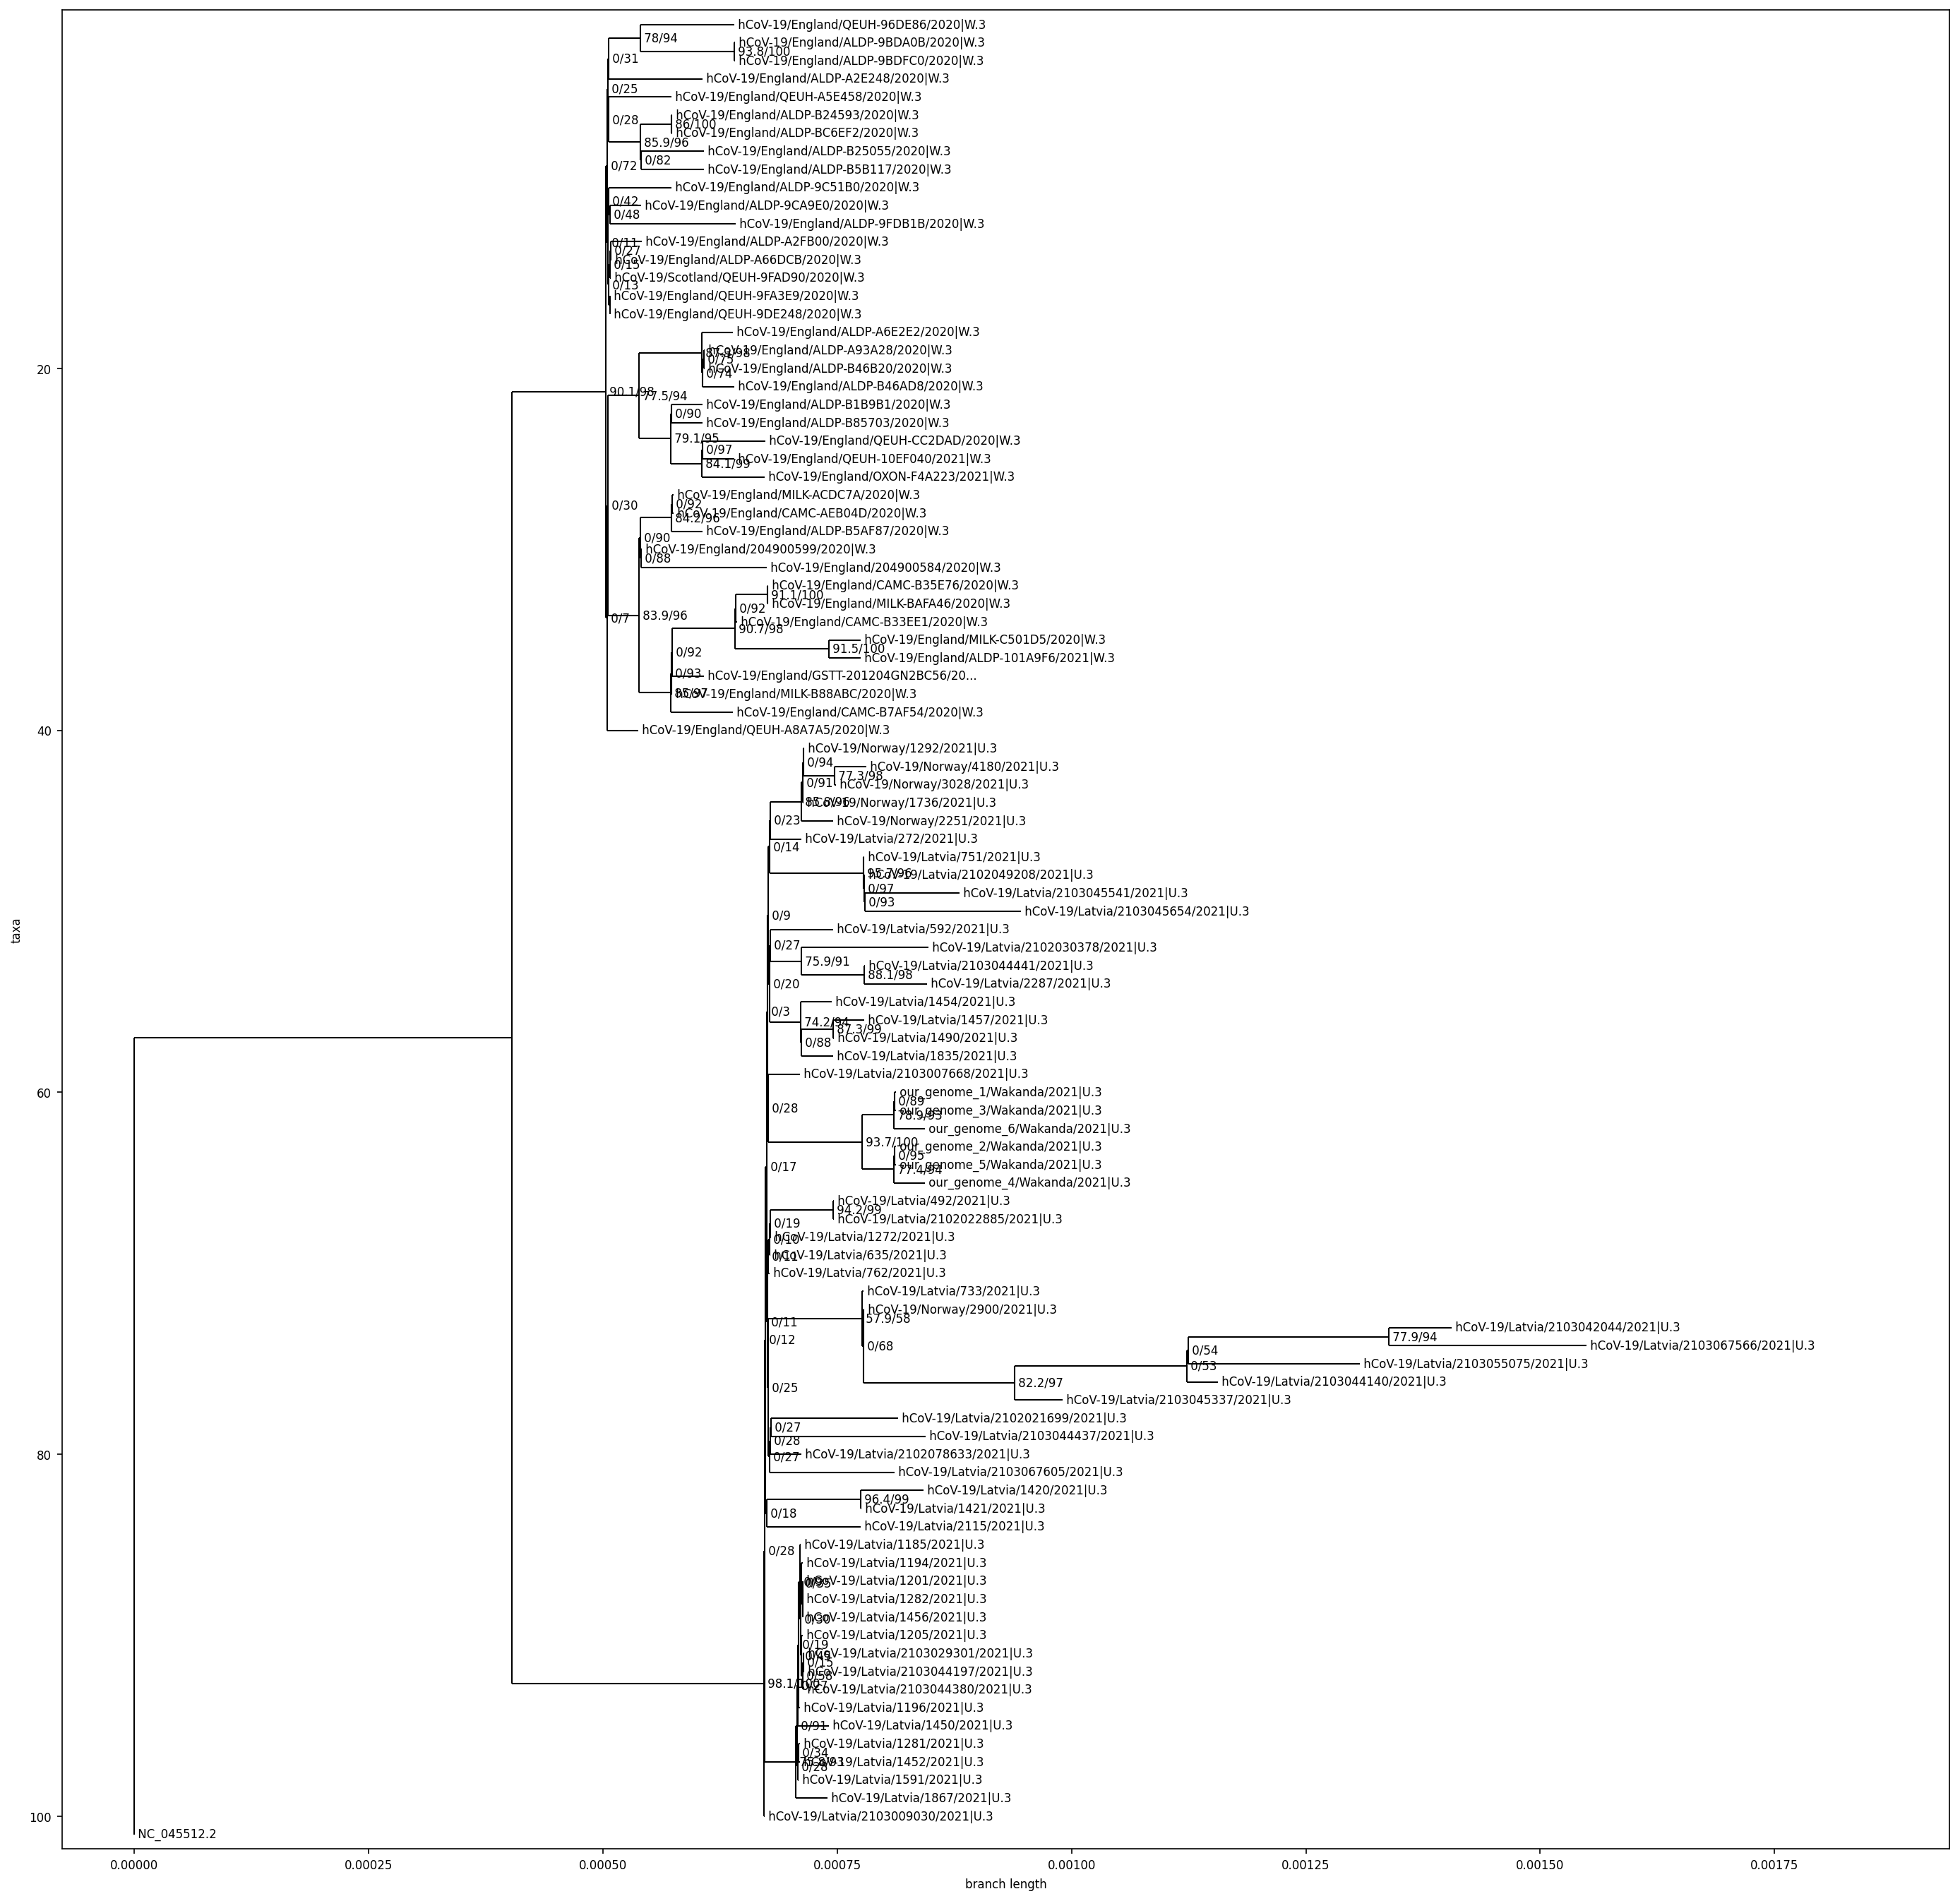

In [31]:
mpl.rcParams['font.size'] = 8

mpl.rcParams['figure.figsize'] = (23, 23)
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['lines.linewidth'] = 1


tree = Phylo.read('selected+reference.fasta.aln.treefile', 'newick')
tree.root_with_outgroup("NC_045512.2")
Phylo.draw(tree)

!seaview selected+reference.fasta.aln.treefile

...and extract the SNPs that originated the new clade

In [49]:
####READ ALN

aln=AlignIO.read("selected+reference.fasta.aln","fasta")

##select the U.3 clade

aln2=MultipleSeqAlignment([])

for i in aln:
    if "U.3" in str(i.id):
        aln2.append(i)
        
##trim alignment 5'

for pos in range(aln2.get_alignment_length()):
    if not "-" in aln[:, pos]:
        p5p = pos
        break

##trim alignment 3'

for pos in reversed(range(aln2.get_alignment_length())):
    if not "-" in aln[:, pos]:
        p3p = pos
        break

aln2=aln2[:, p5p:p3p]

        
###EXTRACT SNPS and compare groups      

DICT={}
for i in range(0,len(aln2[0].seq)):
    POS=list(aln2[:, i])
    if len(set(POS))>1:
        our_clade=[]
        other_taxa=[]

        for y in range(0,len(aln2)):
            if "our_genome".upper() in str(aln2[y].id).upper():
                our_clade.append(aln2[y,i])
            else:
                other_taxa.append(aln2[y,i])
        OUR=max({x:our_clade.count(x) for x in list(set(our_clade))}.items(), key=operator.itemgetter(1))[0]
        OTHER=max({x:other_taxa.count(x) for x in list(set(other_taxa))}.items(), key=operator.itemgetter(1))[0]
        
        if OUR!=OTHER:
            #print(i,OUR,OTHER,our_clade,other_taxa)
            OU=collections.Counter(our_clade)
            OU=",".join([i.upper()+":"+str(OU[i]) for i in OU])
            OT=collections.Counter(other_taxa)
            OT=",".join([i.upper()+":"+str(OT[i]) for i in OT])
            DICT[i]={"PREVALENT_IN_CLADE":OUR.upper(),"PREVALENT_OUTSIDE":OTHER.upper(),"INSIDE_COUNT":OU, "OUTSIDE_COUNT":OT}
        
df=pd.DataFrame.from_dict(DICT, orient="index")
print(df)

      PREVALENT_IN_CLADE PREVALENT_OUTSIDE INSIDE_COUNT OUTSIDE_COUNT
21532                  G                 C          G:6          C:54
21610                  A                 G      G:3,A:3          G:54
21725                  T                 C          T:6          C:54
21768                  A                 T          A:6          T:54
